# Aggregate at census block group level (12 digit GEOID) 


## There are two main ways to join these tiles to another geographic dataset: quadkeys and spatial joins. This notebook will use the spatial join approach.

In [90]:
# !pip3 install geopandas
# !pip3 install adjustText
# !pip3 install elasticsearch
# !pip3 install tobler
# !pip3 install mapclassify

  Using cached tobler-0.8.2-py3-none-any.whl (30 kB)
  Using cached libpysal-4.5.1-py3-none-any.whl (2.4 MB)
     |████████████████████████████████| 987 kB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 21.1 MB 12.9 MB/s eta 0:00:01
  Using cached rasterstats-0.15.0-py3-none-any.whl (16 kB)
  Using cached affine-2.3.0-py2.py3-none-any.whl (15 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
     |████████████████████████████████| 74 kB 2.7 MB/s eta 0:00:011


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import datetime

import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point
from adjustText import adjust_text

from elasticsearch import Elasticsearch, helpers
es = Elasticsearch(['https://3d6a9dd50c7c49c9ab5d23b6891bc03e.us-central1.gcp.cloud.es.io:9243'], 
                    http_auth=('elastic', 'WMzYk5RXyzE7MRShwPVwHzPX'))

import json

from tobler.area_weighted import area_interpolate
from tobler.dasymetric import masked_area_interpolate
import seaborn as sns
from scipy.stats import sem
from scipy.stats import zscore

from numpy import arange
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, MultiTaskLasso, LassoCV, MultiTaskLassoCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate


ModuleNotFoundError: No module named 'adjustText'

## Download Ookla global speed test data, 2021 quarter 3 (on or after 2021-07-01 and before 2021-10-01)

In [3]:
def quarter_start(year: int, q: int) -> datetime:
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)


def get_tile_url(service_type: str, year: int, q: int) -> str:
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [ ]:
# # NOTE: performance_fixed_tiles - Tiles containing tests taken from mobile devices with GPS-quality location and a non-cellular connection type (e.g. WiFi, ethernet).

# # 'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2021/quarter%3D3/2021-07-01_performance_fixed_tiles.zip'
# tile_url = get_tile_url("fixed", 2021, 4) 
# # THIS QUERY TAKES A LONG TIME
# all_tiles = gp.read_file(tile_url)
tile_url


In [16]:
# NOTE: performance_fixed_tiles - Tiles containing tests taken from mobile devices with GPS-quality location and a non-cellular connection type (e.g. WiFi, ethernet).

# # 'https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2021/quarter%3D3/2021-07-01_performance_fixed_tiles.zip'
# tile_url = get_tile_url("fixed", 2021, 3) 
# THIS QUERY TAKES A LONG TIME
# all_tiles = gp.read_file(tile_url)

all_ookla_global_tiles = gp.read_file('2021-07-01_performance_fixed_tiles.zip')

In [17]:
all_ookla_global_tiles.shape #(6929484, 7) 

(6929484, 7)

In [18]:
all_ookla_global_tiles.head(2)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,0320102100110313,232107,26768,14,27,10,"POLYGON ((-77.04163 38.80119, -77.03613 38.801..."
1,1322122000111322,133336,139872,6,85,12,"POLYGON ((101.57959 13.88608, 101.58508 13.886..."


## CONSTANTS

In [19]:
STATE_FIPS_DICT_52 = { '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', 
                      '06': 'CA', '08': 'CO', '09': 'CT', '10': 'DE', 
                      '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI', 
                      '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', 
                      '20': 'KS', '21': 'KY', '22': 'LA', '23': 'ME', 
                      '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN', 
                      '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', 
                      '32': 'NV', '33': 'NH', '34': 'NJ', '35': 'NM', 
                      '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH', 
                      '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', 
                      '45': 'SC', '46': 'SD', '47': 'TN', '48': 'TX', 
                      '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA', 
                      '54': 'WV', '55': 'WI', '56': 'WY', '72': 'PR'}

STATE_LIST_52 = list(sorted(STATE_FIPS_DICT_52.keys()))

COLUMNS_LIST = ['GEOID'                ,
                "statefips"            ,
                "speedCatOokla"        , # BASED ON MEDIAN SPEED
                'numTestOokla'         ,
                'numDeviceOokla'       ,
                "meanUploadMbpsOokla"  ,
                "meanDownloadMbpsOokla",
                "medUploadMbpsOokla"   ,
                "medDownloadMbpsOokla" ,
                "minUploadMbpsOokla"   ,
                "minDownloadMbpsOokla" ,
                "maxUploadMbpsOokla"   ,
                "maxDownloadMbpsOokla" ,]


In [20]:
# ALL_DATA stores every speed result ever calculated; Slow to compute; Carefully preserve this MASTER variable
# ALL_DATA = {'ct': {}, 'cbg': {}, 'cb': {}, 'county': {}}


## Filter Ookla tiles using state shp

In [21]:
census_year = 2019
# states_url = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/STATE/tl_{census_year}_us_state.zip"
STATE_BOUNDARIES = gp.read_file('tl_2019_us_state.zip')

In [22]:
STATE_BOUNDARIES.shape # (56, 15)

(56, 15)

In [23]:
# # GLOBAL VARIABLE that holds Ookla tiles for each state; Slow to compute; Carefully preserve this MASTER variable
# OOKLA_TILES_BY_STATE = {}

# # COUNTY geometry dictionary
# COUNTY_TILES_BY_STATE = {}


In [24]:
for statefips in STATE_LIST_52:
    state = STATE_BOUNDARIES.loc[STATE_BOUNDARIES['STATEFP'] == statefips]
    # Reproject to match the ookla tiles' crs
    state.to_crs(4326)
    xmin, ymin, xmax, ymax = state.total_bounds
    state_tiles = all_ookla_global_tiles.cx[xmin:xmax, ymin:ymax]
    state_name = state['NAME'].iloc[0]
    OOKLA_TILES_BY_STATE[statefips] = (state_name, state_tiles)
    print("Completed filtering ookla tiles to state-level: ", statefips, state_name)

Completed filtering ookla tiles to state-level:  01 Alabama
Completed filtering ookla tiles to state-level:  02 Alaska
Completed filtering ookla tiles to state-level:  04 Arizona
Completed filtering ookla tiles to state-level:  05 Arkansas
Completed filtering ookla tiles to state-level:  06 California
Completed filtering ookla tiles to state-level:  08 Colorado
Completed filtering ookla tiles to state-level:  09 Connecticut
Completed filtering ookla tiles to state-level:  10 Delaware
Completed filtering ookla tiles to state-level:  11 District of Columbia
Completed filtering ookla tiles to state-level:  12 Florida
Completed filtering ookla tiles to state-level:  13 Georgia
Completed filtering ookla tiles to state-level:  15 Hawaii
Completed filtering ookla tiles to state-level:  16 Idaho
Completed filtering ookla tiles to state-level:  17 Illinois
Completed filtering ookla tiles to state-level:  18 Indiana
Completed filtering ookla tiles to state-level:  19 Iowa
Completed filtering ook

In [25]:
# MO sample case
state_name, state_ookla_tiles = OOKLA_TILES_BY_STATE["29"]
state_ookla_tiles.shape 
# From 6,929,484 (global) tiles to 63,638 (for MO state) tiles! Yay

(63638, 7)

In [26]:
COUNTY_BOUNDARIES_URL = f"https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip"
ALL_STATE_COUNTY_TILES = gp.read_file(COUNTY_BOUNDARIES_URL)
for statefips in STATE_LIST_52:
    COUNTY_TILES_BY_STATE[statefips] = ALL_STATE_COUNTY_TILES.loc[ALL_STATE_COUNTY_TILES['STATEFP'] == statefips]
    

## Weight the Ookla result

In [27]:
def aggregated_speed_ookla(ookla_tiles):
    # convert to Mbps for easier reading
    ookla_tiles['avg_d_mbps'] = ookla_tiles['avg_d_kbps'] / 1000
    ookla_tiles['avg_u_mbps'] = ookla_tiles['avg_u_kbps'] / 1000
    
    # weighted average speed
    return (
        ookla_tiles.groupby(["GEOID"])
        .apply(
            lambda x: pd.Series(
                {
                    "meanDownloadMbpsOokla": np.average(x["avg_d_mbps"], weights=x["tests"]),
                    "meanUploadMbpsOokla": np.average(x["avg_u_mbps"], weights=x["tests"]),
                    "medDownloadMbpsOokla": np.median(x["avg_d_mbps"]),
                    "medUploadMbpsOokla": np.median(x["avg_u_mbps"]),
                    'maxDownloadMbpsOokla': np.max(x['avg_d_mbps']),
                    'maxUploadMbpsOokla': np.max(x['avg_u_mbps']),
                    'minDownloadMbpsOokla': np.min(x['avg_d_mbps']),
                    'minUploadMbpsOokla': np.min(x['avg_u_mbps']),
                }
            )
        )
        .reset_index()
        .merge(
            ookla_tiles.groupby(["GEOID"])
            .agg(numTestOokla=("tests", "sum"), numDeviceOokla=("devices", "sum"))
            .reset_index(),
            on=["GEOID"],
        )
        .round(2) # round to 2 decimal places for easier reading
    )


## Validate speeds against Indicators of Broadband Need Map (Ookla 2020q1q2 Median speed @ Tract Level) 
SAMPLE case: Missouri tracts, statefips = 29, 
https://www.arcgis.com/apps/webappviewer/index.html?id=ba2dcd585f5e43cba41b7c1ebf2a43d0


In [35]:
# THIS QUERY TAKES A LONG TIME
# Between "2020-01-01" AND "2020-07-01" 
# NTIA_global_ookla_tiles_q1 = gp.read_file(get_tile_url("fixed", 2020, 1) )
# NTIA_global_ookla_tiles_q2 = gp.read_file(get_tile_url("fixed", 2020, 2) )


In [ ]:
statefips = "29"
state = STATE_BOUNDARIES.loc[STATE_BOUNDARIES['STATEFP'] == statefips]
# Reproject to match the ookla tiles' crs
state.to_crs(4326)
state_name = state['NAME'].iloc[0]
xmin, ymin, xmax, ymax = state.total_bounds

state_tiles_q1 = NTIA_global_ookla_tiles_q1.cx[xmin:xmax, ymin:ymax]
state_tiles_q2 = NTIA_global_ookla_tiles_q2.cx[xmin:xmax, ymin:ymax]

# concat ookla tiles from 2020q1 and 2020q2
joined_state_ookla_tiles = pd.concat([state_tiles_q1, state_tiles_q2], ignore_index=True)

In [167]:
state_tiles_q1.shape # (66969, 7)
state_tiles_q2.shape # (68674, 7)
joined_state_ookla_tiles.shape # (135643, 7)

(135643, 7)

### 2020 Census Tracts

In [156]:
census_year = 2020
# https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_01_tract.zip
state_shp_url_2020 = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/TRACT/tl_{census_year}_{statefips}_tract.zip"
state_census_tiles_2020 = gp.read_file(state_shp_url_2020)

# NOTE: much difference (a lot more census tracts comparing to 2010-2019)
len(state_census_tiles_2020['GEOID'].unique()) # 1654

In [163]:
# Reproject to match the tiles
state_census_tiles_2020 = state_census_tiles_2020.to_crs(4326)
# Join the ookla tiles to the census boundaries. 
# how="inner": only includes census-level boundaries that have at least 1 tile.
joined_tiles_2020 = gp.sjoin(joined_state_ookla_tiles, state_census_tiles_2020, how="inner", predicate='intersects')
joined_tiles_2020.shape # 2020= ((107144,)

1650

In [ ]:
len(joined_tiles_2020['GEOID'].unique()) # 1650
# weighted_df_2020 = aggregated_speed_ookla(joined_tiles_2020)
# ... etc.

### 2019 Census Tracts

In [165]:
census_year = 2019
state_shp_url_2019 = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/TRACT/tl_{census_year}_{statefips}_tract.zip"
state_census_tiles_2019 = gp.read_file(state_shp_url)
state_census_tiles_2019 = state_census_tiles_2019.to_crs(4326)
len(state_census_tiles_2019['GEOID'].unique()) # 1393

In [168]:
joined_tiles_2019 = gp.sjoin(joined_state_ookla_tiles, state_census_tiles_2019, how="inner", predicate='intersects')
joined_tiles_2019.shape # (103845, 20)

(103845, 20)

In [169]:
# Weight test results. NOTE the column_to_group
weighted_df_2019 = aggregated_speed_ookla(joined_tiles_2019)
len(joined_tiles_2019['GEOID'].unique()) # 1390
weighted_df_2019.shape # (1390, 7) vs 1,393 census tracts in Missouri (2010 US Tally)

(1390, 11)

### 2010 Census Tracts

In [170]:
census_year = 2010
# NOTE 2010 special format url
state_shp_url_2010 = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/TRACT/{census_year}/tl_{census_year}_{statefips}_tract10.zip"
state_census_tiles_2010 = gp.read_file(state_shp_url_2010)
len(state_census_tiles_2010['GEOID10'].unique()) # 1393

1393

In [171]:
state_census_tiles_2010 = state_census_tiles_2010.to_crs(4326)
joined_tiles_2010 = gp.sjoin(joined_state_ookla_tiles, state_census_tiles_2010, how="inner", predicate='intersects')
joined_tiles_2010 = joined_tiles_2010.rename(columns={'GEOID10':'GEOID'})
joined_tiles_2010.shape # (103865, 20)

(103865, 20)

In [ ]:
weighted_df_2010 = aggregated_speed_ookla(joined_tiles_2010)
len(joined_tiles_2010['GEOID'].unique()) # 1390
weighted_df_2010.shape # (1390, 11)

### Compare/Validate against: NTIA Ookla median speeds

In [213]:
ntia_ookla_results = pd.read_csv('NTIA-Ookla-MO-tracts.csv')
ntia_ookla_results['GEOID'] = ntia_ookla_results['Geographic Identifier - FIPS Code'].apply(str)
ntia_ookla_results[['GEOID', 'Ookla Median Download Speed (Mbps)', 'Ookla Median Upload Speed (Mbps)']]
ntia_ookla_results = ntia_ookla_results[['GEOID', 'Ookla Median Download Speed (Mbps)', 'Ookla Median Upload Speed (Mbps)']].round(2)
ntia_ookla_results = ntia_ookla_results.rename(columns={'Ookla Median Download Speed (Mbps)': 'medDownloadMbpsOoklaNTIA', 'Ookla Median Upload Speed (Mbps)': 'medUploadMbpsOoklaNTIA'})
ntia_ookla_results.shape # (1393, 3)

(1393, 3)

In [214]:
ntia_ookla_results.head()

,GEOID,medDownloadMbpsOoklaNTIA,medUploadMbpsOoklaNTIA
0,29001950100,19.52,7.04
1,29001950200,28.54,23.59
2,29001950300,41.56,10.33
3,29001950400,50.13,10.79
4,29001950500,58.20,10.89


In [215]:
# weighted_df_2010
# weighted_df_2020

weighted_df_2019_sim = weighted_df_2019[['GEOID', 'medDownloadMbpsOokla', 'medUploadMbpsOokla']]
weighted_df_2019_sim.shape # (1390, 3)


(1390, 3)

In [216]:
set(ntia_ookla_results['GEOID'].unique()) - set(weighted_df_2019_sim['GEOID'].unique()) # {'29087960300', '29197470200', '29199480200'}

{'29087960300', '29197470200', '29199480200'}

In [253]:
merged_df = ntia_ookla_results.merge(weighted_df_2019_sim, how='left', on='GEOID')
merged_df.shape # (1393, 5)
merged_df[merged_df.isnull().any(axis=1)]

,GEOID,medDownloadMbpsOoklaNTIA,medUploadMbpsOoklaNTIA,medDownloadMbpsOokla,medUploadMbpsOokla
396,29087960300,9.34,0.96,NaN,NaN
1205,29197470200,18.65,7.29,NaN,NaN
1207,29199480200,23.86,20.84,NaN,NaN


In [254]:
all_means = merged_df.mean()[1:]
all_means

medDownloadMbpsOoklaNTIA     77.381723
medUploadMbpsOoklaNTIA       16.440826
medDownloadMbpsOokla        100.254676
medUploadMbpsOokla           26.609158
dtype: float64

In [255]:
# NOTE: vastly inaccurate
all_means[2]/all_means[0], all_means[3]/all_means[1]

(1.2955859924219106, 1.6184806646220251)

In [223]:
merged_df.sample(frac=.1, random_state=1)[:15]

# TODO HERE NOW : check 
# ARCGIS methodology ``which accounts for user test-taking practices that may skew the median value for a given geography``


,GEOID,medDownloadMbpsOoklaNTIA,medUploadMbpsOoklaNTIA,medDownloadMbpsOokla,medUploadMbpsOokla
966,29183312095,103.44,10.77,89.87,11.07
439,29095005801,49.07,11.75,153.45,26.72
876,29169470400,24.94,4.73,31.62,4.42
1323,29510108200,94.12,11.36,170.33,14.73
478,29095010103,64.95,22.26,140.07,44.90
236,29049960100,96.57,79.57,130.13,109.19
1356,29510116302,144.37,11.83,176.06,58.41
1162,29189220601,122.17,12.68,143.93,60.13
255,29053950100,87.01,86.89,101.26,100.14
490,29095011401,114.16,17.61,123.91,17.13


## Categorize the speeds
Here I choose to separate into 3 download and 3 upload speed categories.

In [28]:
def add_speed_category_column(weighted_ookla_data):
    def helper(row):
        if row['medDownloadMbpsOokla'] < 25 or row['medUploadMbpsOokla'] < 3:
            return 0 # unserved
        if row['medDownloadMbpsOokla'] < 100 or row['medUploadMbpsOokla'] < 20:
            return 1 # underserved
        return 2
    # again: the speed category is based on the MEDIAN speeds
    weighted_ookla_data['speedCatOokla'] = weighted_ookla_data.apply(helper, axis = 1)


## ES resolver utils
https://elasticsearch-py.readthedocs.io/en/v7.15.0/api.html

In [29]:
def create_index(es, ES_ROW_GEOID, index_name):
    create_request_body = {
       "settings": {
        "refresh_interval": "1s",
        "number_of_shards": 1,
        "number_of_replicas": 0
      },
        "mappings":{
            "properties":{
                ES_ROW_GEOID             : { "type":"text"},
                "statefips"              : { "type": "text" },
                "speedCatOokla"          : { "type": "integer" },
                'numTestOokla'           : { "type": "integer"},
                'numDeviceOokla'         : { "type": "integer"},
                "meanUploadMbpsOokla"    : { "type": "float" },
                "meanDownloadMbpsOokla"  : { "type": "float" },
                "medUploadMbpsOokla"     : { "type": "float" },
                "medDownloadMbpsOokla"   : { "type": "float" },
                "minUploadMbpsOokla"     : { "type": "float" },
                "minDownloadMbpsOokla"   : { "type": "float" },
                "maxUploadMbpsOokla"     : { "type": "float" },
                "maxDownloadMbpsOokla"   : { "type": "float" },
            }
        }
    } 

    es.indices.create(index = index_name, body = create_request_body)
    print('created index ', index_name)

def delete_index(es, index_name):
    es.indices.delete(index=index_name, ignore=[400, 404])
    print('deleted index ', index_name)
    
# https://elasticsearch-py.readthedocs.io/en/v7.15.0/api.html#elasticsearch.client.IndicesClient.put_mapping\n",
def update_index(es, index_name):
    # adding new fields
    update_request_body = {
        "properties":{
                "statefips"              : { "type": "text" },
                "speedCatOokla"          : { "type": "integer" },
                'numTestOokla'           : { "type": "integer"},
                'numDeviceOokla'         : { "type": "integer"},
                "meanUploadMbpsOokla"    : { "type": "float" },
                "meanDownloadMbpsOokla"  : { "type": "float" },
                "medUploadMbpsOokla"     : { "type": "float" },
                "medDownloadMbpsOokla"   : { "type": "float" },
                "minUploadMbpsOokla"     : { "type": "float" },
                "minDownloadMbpsOokla"   : { "type": "float" },
                "maxUploadMbpsOokla"     : { "type": "float" },
                "maxDownloadMbpsOokla"   : { "type": "float" },
        }
    }
    es.indices.put_mapping(index = index_name, body = update_request_body)
    print('updated index ', index_name)
    
def upload_df(es, df, index_name, id_column, op_type):
    # """ This function upload plain json file, not geojson"""
    df = df.to_json(orient = 'records')
    json_records = json.loads(df)
    action_list = []
    for row in json_records:
        record = {
            # 'index' = ES automatically knows to create or update (entire record/ not partial record), depending on situations
            # 'index' op_type actually overwrites entirety of any existing records. 
            '_op_type': op_type,
            '_index': index_name,
            # The type of the document
            "_type": '_doc', 
            '_id':row[id_column],

        }
        # Goal: if the document doesn't exist, insert my partial doc. 
        # If it already exists, update it with the partial doc.
        # update https://elasticsearch-py.readthedocs.io/en/7.x/api.html#elasticsearch.Elasticsearch.update
        # update https://stackoverflow.com/a/42875769
        if op_type == 'update':
            record['doc_as_upsert'] = True
            record['doc'] = row
            # "doc": {"newkey": 'newvalue'},
        elif op_type == 'index':
            # a comma-separated list of the fields you want to retrieve.'
            record['_source'] = row
        else:
            print('upload_df only accepts `update` or `index`')
                   
        action_list.append(record)
        
    # UPLOAD the records
    helpers.bulk(es, action_list)
    print(f"finished uploading {len(json_records)} records to {index_name}")
    


## MAIN Function: Ookla

In [30]:
def generate_ookla_data_by_state(
    statelist, 
    census_year, 
    census_level,
    ES_ROW_GEOID):
    
    if census_level not in {'county', 'ct', 'cbg', 'cb'}:
        print(f"shp/boundaries census_level {census_level} is not supported")
    else:  
        for statefips in statelist: 
            if census_level == 'ct':
                state_shp_url = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/TRACT/tl_{census_year}_{statefips}_tract.zip"
                state_census_tiles = gp.read_file(state_shp_url)
            elif census_level == 'cbg': # CENSUS BLOCK GROUP
                state_shp_url = f"https://www2.census.gov/geo/tiger/TIGER{census_year}/BG/tl_{census_year}_{statefips}_bg.zip"
                state_census_tiles = gp.read_file(state_shp_url)
            elif census_level == 'cb': # CENSUS BLOCK
                state_shp_url = f"https://www2.census.gov/geo/tiger/TIGER2020/TABBLOCK/tl_2020_{statefips}_tabblock10.zip"
                state_census_tiles = gp.read_file(state_shp_url)
                # cb TIGER shp 2020: cb year 2010, has GEOID10 field, instead of regular GEOID
                state_census_tiles = state_census_tiles.rename({"GEOID10": "GEOID"}, axis = 1)
            elif census_level == 'county':
                # NOTE: Got a single tiger shp for all counties in entire U.S.
                state_census_tiles = COUNTY_TILES_BY_STATE[statefips]

            # Reproject to match the tiles
            state_census_tiles = state_census_tiles.to_crs(4326)
            # Filter state ookla tiles (by state bounding box)
            state_name, state_ookla_tiles = OOKLA_TILES_BY_STATE[statefips]
            # Note: edge case where there are no ookla tiles within state bounding box
            if state_ookla_tiles.shape[0] > 0:
                # Join the ookla tiles to the census boundaries. 
                # how="inner": only includes census-level boundaries that have at least 1 tile.
                joined_tiles = gp.sjoin(state_ookla_tiles, state_census_tiles, how="inner", predicate='intersects')

                # Note: edge case where there are no joined ookla tiles
                if joined_tiles.shape[0] > 0:
                    # Weight test results. NOTE the column_to_group
                    weighted_df = aggregated_speed_ookla(joined_tiles)
                    # Categorize the speeds
                    add_speed_category_column(weighted_df)

                    if sorted(weighted_df.columns.tolist()) != sorted(COLUMNS_LIST):
                        print("NOTE: Header not expected (double-check the GEOID field): ")

                    # RENAME the GEOID column to match ES mapping
                    weighted_df = weighted_df.rename({"GEOID": ES_ROW_GEOID}, axis = 1)

                    # Add statefips column
                    weighted_df = weighted_df.assign(statefips=statefips)

                    # STORE the result
                    ALL_DATA[census_level][statefips] = weighted_df
                    print(f"{state_name} fips={statefips}: generated {weighted_df.shape[0]} {census_level}(s) with ookla results")
        
        print("Completed generating ookla data for all states")

# GENERATE OOKLA DATA

## Generate ookla COUNTY

In [31]:
MO_only_list = ['29']

### Generate all  COUNTY level Ookla data
generate_ookla_data_by_state(
    statelist = STATE_LIST_52, 
    # statelist = MO_only_list, 
    census_year = 2019, 
    census_level = 'county',
    ES_ROW_GEOID = 'GEOID_c')

# MS has 82 COUNTIES
# MO has 114 COUNTIES

NOTE: Header not expected (double-check the GEOID field): 
Alabama fips=01: generated 67 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Alaska fips=02: generated 27 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Arizona fips=04: generated 15 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Arkansas fips=05: generated 75 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
California fips=06: generated 58 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Colorado fips=08: generated 64 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Connecticut fips=09: generated 8 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Delaware fips=10: generated 3 county(s) with ookla results
NOTE: Header not expected (double-check the GEOID

In [32]:
ALL_DATA['county']['28'].head()

,GEOID_c,meanDownloadMbpsOokla,meanUploadMbpsOokla,medDownloadMbpsOokla,medUploadMbpsOokla,maxDownloadMbpsOokla,maxUploadMbpsOokla,minDownloadMbpsOokla,minUploadMbpsOokla,numTestOokla,numDeviceOokla,speedCatOokla,statefips
0,28001,110.38,42.77,65.14,13.35,358.62,531.43,0.52,0.05,1128,435,1,28
1,28003,171.72,129.41,182.99,111.74,825.06,780.24,0.54,0.06,1931,622,2,28
2,28005,36.02,10.89,16.94,2.29,146.76,127.88,0.23,0.26,319,96,0,28
3,28007,54.21,17.85,31.60,3.53,393.76,405.52,0.99,0.24,663,202,1,28
4,28009,153.00,124.05,185.03,154.10,591.40,580.68,2.09,0.21,391,102,2,28


## Generate ookla TRACT

In [33]:
### Generate all census tract-level Ookla data
done_cb_list = ['29', '01', '02']
generate_ookla_data_by_state(
    statelist = sorted(list(set(STATE_LIST_52) - set(done_cb_list))),
    # statelist = STATE_LIST_52, 
    # statelist = MO_only_list, 
    census_year = 2019, 
    census_level = 'ct',
    ES_ROW_GEOID = 'GEOID_ct')


NOTE: Header not expected (double-check the GEOID field): 
Arizona fips=04: generated 1523 ct(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Arkansas fips=05: generated 685 ct(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
California fips=06: generated 8045 ct(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Colorado fips=08: generated 1245 ct(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Connecticut fips=09: generated 831 ct(s) with ookla results


KeyboardInterrupt: 

In [ ]:
ALL_DATA['ct']['27'].head()

## Generate ookla BLOCKGROUP

In [ ]:
### Generate all CBG-level Ookla data
done_cb_list = ['29', '01']
generate_ookla_data_by_state(
    statelist = sorted(list(set(STATE_LIST_52) - set(done_cb_list))),
    # statelist = STATE_LIST_52, 
    # statelist = MO_only_list, 
    census_year = 2019, 
    census_level = 'cbg',
    ES_ROW_GEOID = 'GEOID_cbg')


In [ ]:
ALL_DATA['cbg']['01'].head()
ALL_DATA['cbg']['01'].shape # (3426, 13)

In [ ]:
ALL_DATA['cbg']['29'].head()

## Generate ookla CENSUSBLOCK

In [423]:
### Generate all census block Ookla data
done_cb_list = ['29', '01', '02', '04', '05']
generate_ookla_data_by_state(
    statelist = sorted(list(set(STATE_LIST_52) - set(done_cb_list))),
    # statelist = STATE_LIST_52, 
    # statelist = MO_only_list, 
    census_year = 2019, 
    census_level = 'cb',
    ES_ROW_GEOID = 'GEOID')



NOTE: Header not expected (double-check the GEOID field): 
California fips=06: generated 500753 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Colorado fips=08: generated 123015 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Connecticut fips=09: generated 57678 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Delaware fips=10: generated 19303 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
District of Columbia fips=11: generated 6280 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Florida fips=12: generated 382561 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Georgia fips=13: generated 175292 cb(s) with ookla results
NOTE: Header not expected (double-check the GEOID field): 
Hawaii fips=15: generated 16190 cb(s) with ookla results
NOTE: Header not expected (double-check 

In [426]:
ALL_DATA['cb']['72'].head()

,GEOID,meanDownloadMbpsOokla,meanUploadMbpsOokla,medDownloadMbpsOokla,medUploadMbpsOokla,maxDownloadMbpsOokla,maxUploadMbpsOokla,minDownloadMbpsOokla,minUploadMbpsOokla,numTestOokla,numDeviceOokla,speedCatOokla,statefips
0,720019563001000,4.44,3.98,4.44,3.98,4.44,3.98,4.44,3.98,11,2,0,72
1,720019563001008,6.41,2.15,6.41,2.15,6.41,2.15,6.41,2.15,4,1,0,72
2,720019563001009,5.95,2.42,5.26,2.83,6.41,3.51,4.10,2.15,5,2,0,72
3,720019563001011,6.41,2.15,6.41,2.15,6.41,2.15,6.41,2.15,4,1,0,72
4,720019563001012,6.41,2.15,6.41,2.15,6.41,2.15,6.41,2.15,4,1,0,72


In [451]:
ALL_DATA['cb']['29'].head()
# ALL_DATA['cb']['29'].shape # (164589, 13) vs 343,565 census blocks in MO

,GEOID,meanDownloadMbpsOokla,meanUploadMbpsOokla,medDownloadMbpsOokla,medUploadMbpsOokla,maxDownloadMbpsOokla,maxUploadMbpsOokla,minDownloadMbpsOokla,minUploadMbpsOokla,numTestOokla,numDeviceOokla,speedCatOokla,statefips
0,290019501001124,132.39,37.28,132.39,37.28,132.39,37.28,132.39,37.28,3,1,2,29
1,290019501001127,132.39,37.28,132.39,37.28,132.39,37.28,132.39,37.28,3,1,2,29
2,290019501001129,99.00,15.38,100.18,11.88,113.50,31.24,83.32,3.01,3,3,1,29
3,290019501001131,91.75,21.56,91.75,21.56,100.18,31.24,83.32,11.88,2,2,1,29
4,290019501001133,91.75,21.56,91.75,21.56,100.18,31.24,83.32,11.88,2,2,1,29


## Intermediate backup

In [427]:
import copy
# BACK UP MASTER data -- in case accidentally removed ALL_DATA
ALL_DATA_BACKUP = copy.deepcopy(ALL_DATA)

In [428]:
%store ALL_DATA

Stored 'ALL_DATA' (dict)


In [432]:
%store

Stored variables and their in-db values:
ALL_DATA                          -> {'ct': {'29':          GEOID_ct  meanDownloadMbpsO
COUNTY_TILES_BY_STATE             -> {'01':      STATEFP COUNTYFP  COUNTYNS  GEOID     
OOKLA_TILES_BY_STATE              -> {'01': ('Alabama',                   quadkey  avg_


In [433]:
#  3206 (vs 3233 total counties in US Tiger shp 2019) 
sum(map(lambda fips: ALL_DATA['county'][fips].shape[0], STATE_LIST_52))

3206

In [434]:
#  73772 (vs in the US 2010 tally: 73,057)
sum(map(lambda fips: ALL_DATA['ct'][fips].shape[0], STATE_LIST_52))

73772

In [431]:
#  219457 (vs in the US 2010 tally: 217,740)
sum(map(lambda fips: ALL_DATA['cbg'][fips].shape[0], STATE_LIST_52))

219457

# UPLOAD Ookla data TO ES

### UPLOAD COUNTY: to existing index boss_county

In [405]:
index_name = "boss_county"
census_level = 'county'
ES_ROW_GEOID = 'GEOID_c'

# RUN ONCE
# update_index(es, index_name)

for statefips in STATE_LIST_52:
    df = ALL_DATA['county'][statefips]
    # UPLOAD/UPDATE data in the index: RUN ONCE
    # upload_df(es, df, index_name, ES_ROW_GEOID, 'update')

finished uploading 67 records to boss_county
finished uploading 27 records to boss_county
finished uploading 15 records to boss_county
finished uploading 75 records to boss_county
finished uploading 58 records to boss_county
finished uploading 64 records to boss_county
finished uploading 8 records to boss_county
finished uploading 3 records to boss_county
finished uploading 1 records to boss_county
finished uploading 67 records to boss_county
finished uploading 158 records to boss_county
finished uploading 5 records to boss_county
finished uploading 44 records to boss_county
finished uploading 102 records to boss_county
finished uploading 92 records to boss_county
finished uploading 99 records to boss_county
finished uploading 105 records to boss_county
finished uploading 120 records to boss_county
finished uploading 64 records to boss_county
finished uploading 16 records to boss_county
finished uploading 24 records to boss_county
finished uploading 14 records to boss_county
finished u

### Adding some empty records with populated GEOID_c and statfips so that we can drop 2 fields: countyfip and STATEFP

### Little experiment with number of counties in different years:

In [753]:
tdf2011 = gp.read_file('https://www2.census.gov/geo/tiger/TIGER2011/COUNTY/tl_2011_us_county.zip')
tdf2019 = gp.read_file('https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip')
tdf2020 = gp.read_file('https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip')

tdf2011.shape # (3234, 18)
tdf2019.shape # (3233, 18)
tdf2020.shape # (3234, 18)

counties2020 = set(tdf2020['GEOID'].unique())
counties2019 = set(tdf2019['GEOID'].unique())
counties2011 = set(tdf2011['GEOID'].unique())

counties2020 - counties2019 # {'02063', '02066'}
counties2019 - counties2020 # {'02261'}

counties2020 - counties2011 # {'02063', '02066', '02158', '46102'}
counties2011 - counties2020 # {'02261', '02270', '46113', '51515'}


### Upsert empty record for counties (census 2019) without ookla data 

In [806]:
counties_with_ookla_data = set()
for fips in STATE_LIST_52:
    counties_with_ookla_data.update(ALL_DATA['county'][fips]['GEOID_c'].unique())

no_result_county = set(tdf2019['GEOID'].unique()) - counties_with_ookla_data
len(no_result_county) # 27
# plus 2 counties not in tiger2019: 02270, 46113
no_result_county.update(['02270', '46113'])
len(no_result_county) # 29

# ADD some partial empty records
empty_data = []
for county_id in no_result_county:
    empty_data.append([county_id[:2], county_id])
empty_df = pd.DataFrame(empty_data, columns=['statefips', 'GEOID_c'])
# UPSERT
# upload_df(es, empty_df, "boss_county", "GEOID_c", 'update')


29

## Upload TRACT to new index: speed_ookla_2021q3_ct_all_states

In [439]:
# speed_ookla_2021q3_ct_all_states
index_name = "speed_ookla_2021q3_ct_all_states"
census_level = 'ct'
ES_ROW_GEOID = 'GEOID_ct'

# RUN ONCE
# create_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE
# update_index(es, index_name)

In [440]:
# UPLOAD (create/overwrite new record via op_type index)
for statefips in STATE_LIST_52:
    if statefips in ALL_DATA[census_level]:
        df = ALL_DATA[census_level][statefips]
        # UPLOAD the df; RUN ONCE
        upload_df(es, df, index_name, ES_ROW_GEOID, 'index')


finished uploading 1180 records to speed_ookla_2021q3_ct_all_states
finished uploading 161 records to speed_ookla_2021q3_ct_all_states
finished uploading 1523 records to speed_ookla_2021q3_ct_all_states
finished uploading 685 records to speed_ookla_2021q3_ct_all_states
finished uploading 8045 records to speed_ookla_2021q3_ct_all_states
finished uploading 1245 records to speed_ookla_2021q3_ct_all_states
finished uploading 831 records to speed_ookla_2021q3_ct_all_states
finished uploading 218 records to speed_ookla_2021q3_ct_all_states
finished uploading 179 records to speed_ookla_2021q3_ct_all_states
finished uploading 4227 records to speed_ookla_2021q3_ct_all_states
finished uploading 1961 records to speed_ookla_2021q3_ct_all_states
finished uploading 328 records to speed_ookla_2021q3_ct_all_states
finished uploading 298 records to speed_ookla_2021q3_ct_all_states
finished uploading 3122 records to speed_ookla_2021q3_ct_all_states
finished uploading 1509 records to speed_ookla_2021q3_c

## Upload Ookla BLOCKGROUP to new index: speed_ookla_2021q3_cbg_all_states

In [441]:
census_level = 'cbg'
ES_ROW_GEOID = 'GEOID_cbg'
index_name = "speed_ookla_2021q3_cbg_all_states"

# RUN ONCE
# create_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE
# update_index(es, index_name)

# UPLOAD (create/overwrite new record via op_type index)
for statefips in STATE_LIST_52:
    if statefips in ALL_DATA[census_level]:
        df = ALL_DATA[census_level][statefips]
#         upload_df(es, df, index_name, ES_ROW_GEOID, 'index')
        

finished uploading 3426 records to speed_ookla_2021q3_cbg_all_states
finished uploading 512 records to speed_ookla_2021q3_cbg_all_states
finished uploading 4151 records to speed_ookla_2021q3_cbg_all_states
finished uploading 2130 records to speed_ookla_2021q3_cbg_all_states
finished uploading 23192 records to speed_ookla_2021q3_cbg_all_states
finished uploading 3524 records to speed_ookla_2021q3_cbg_all_states
finished uploading 2583 records to speed_ookla_2021q3_cbg_all_states
finished uploading 573 records to speed_ookla_2021q3_cbg_all_states
finished uploading 450 records to speed_ookla_2021q3_cbg_all_states
finished uploading 11422 records to speed_ookla_2021q3_cbg_all_states
finished uploading 5500 records to speed_ookla_2021q3_cbg_all_states
finished uploading 851 records to speed_ookla_2021q3_cbg_all_states
finished uploading 960 records to speed_ookla_2021q3_cbg_all_states
finished uploading 9675 records to speed_ookla_2021q3_cbg_all_states
finished uploading 4804 records to sp

### Existing index: boss_cbg_{statefips} -- not needed

In [444]:
# census_level = 'cbg'
# ES_ROW_GEOID = 'GEOID_cbg'

# for statefips in STATE_LIST_52:
#     index_name = f"boss_cbg_{statefips}"
#     # just to make sure that the index exists, before updating/uploading
#     if es.indices.exists(index= index_name):
#         df = ALL_DATA[census_level][statefips]
#         # UPDATE mapping, run ONCE
#         update_index(es, index_name)
        
#         # UPLOAD/UPDATE data in the index, RUN ONCE
#         upload_df(es, df, index_name, ES_ROW_GEOID, 'update')

updated index  boss_cbg_01
finished uploading 3426 records to boss_cbg_01
updated index  boss_cbg_02
finished uploading 512 records to boss_cbg_02
updated index  boss_cbg_04
finished uploading 4151 records to boss_cbg_04
updated index  boss_cbg_05
finished uploading 2130 records to boss_cbg_05
updated index  boss_cbg_06
finished uploading 23192 records to boss_cbg_06
updated index  boss_cbg_08
finished uploading 3524 records to boss_cbg_08
updated index  boss_cbg_09
finished uploading 2583 records to boss_cbg_09
updated index  boss_cbg_10
finished uploading 573 records to boss_cbg_10
updated index  boss_cbg_11
finished uploading 450 records to boss_cbg_11
updated index  boss_cbg_12
finished uploading 11422 records to boss_cbg_12
updated index  boss_cbg_13
finished uploading 5500 records to boss_cbg_13
updated index  boss_cbg_15
finished uploading 851 records to boss_cbg_15
updated index  boss_cbg_16
finished uploading 960 records to boss_cbg_16
updated index  boss_cbg_17
finished uploa

## UPLOAD CENSUS BLOCK

### New index: speed_ookla_2021q3_cb_{statefips}

In [449]:
census_level = 'cb'
ES_ROW_GEOID = 'GEOID'


for statefips in STATE_LIST_52:
    index_name = f"speed_ookla_2021q3_cb_{statefips}"
    if statefips in ALL_DATA[census_level]:
        # create new index; RUN ONCE
        # create_index(es, ES_ROW_GEOID, index_name)
        
        # update mapping; RUN ONCE
        update_index(es, index_name)
        
        df = ALL_DATA[census_level][statefips]
        # UPLOAD/UPDATE data in the index, RUN ONCE (op_type index = wipe old data)
        upload_df(es, df, index_name, ES_ROW_GEOID, 'index')
        

updated index  speed_ookla_2021q3_cb_15
finished uploading 16190 records to speed_ookla_2021q3_cb_15
updated index  speed_ookla_2021q3_cb_16
finished uploading 54797 records to speed_ookla_2021q3_cb_16
updated index  speed_ookla_2021q3_cb_17
finished uploading 302334 records to speed_ookla_2021q3_cb_17
updated index  speed_ookla_2021q3_cb_18
finished uploading 170575 records to speed_ookla_2021q3_cb_18
updated index  speed_ookla_2021q3_cb_19
finished uploading 87356 records to speed_ookla_2021q3_cb_19
updated index  speed_ookla_2021q3_cb_20
finished uploading 95938 records to speed_ookla_2021q3_cb_20
updated index  speed_ookla_2021q3_cb_21
finished uploading 93138 records to speed_ookla_2021q3_cb_21
updated index  speed_ookla_2021q3_cb_22
finished uploading 110257 records to speed_ookla_2021q3_cb_22
updated index  speed_ookla_2021q3_cb_23
finished uploading 36534 records to speed_ookla_2021q3_cb_23
updated index  speed_ookla_2021q3_cb_24
finished uploading 102976 records to speed_ookla

### Existing index: bossdata{statefips} -- NOT NEEDED

In [ ]:
# census_level = 'cb'
# ES_ROW_GEOID = 'GEOID'

# for statefips in STATE_LIST_52:
#     index_name = f"bossdata{statefips}"
#     if es.indices.exists(index= index_name):
#         df = ALL_DATA[census_level][statefips]

#         # UPDATE mapping, run ONCE
#         update_index(es, index_name)
        
#         # UPLOAD or UPDATE PARTIAL data in the index, i.e. UPSERT; RUN ONCE
#         upload_df(es, df, index_name, ES_ROW_GEOID, 'update')

# EXPORT to csv to save results

In [450]:
count = 1
for census_level in ['county', 'ct','cbg','cb']:
    for statefips in ALL_DATA[census_level].keys():
        filename = f"db/ookla-2021q3-{statefips}-{census_level}.csv"
        ALL_DATA[census_level][statefips].to_csv(filename, index = False)
        print(f'exported {filename} to csv: ', count)
        count += 1
"COMPLETED EXPORTING"
            

exported db/ookla-2021q3-29-county.csv to csv:  1
exported db/ookla-2021q3-01-county.csv to csv:  2
exported db/ookla-2021q3-02-county.csv to csv:  3
exported db/ookla-2021q3-04-county.csv to csv:  4
exported db/ookla-2021q3-05-county.csv to csv:  5
exported db/ookla-2021q3-06-county.csv to csv:  6
exported db/ookla-2021q3-08-county.csv to csv:  7
exported db/ookla-2021q3-09-county.csv to csv:  8
exported db/ookla-2021q3-10-county.csv to csv:  9
exported db/ookla-2021q3-11-county.csv to csv:  10
exported db/ookla-2021q3-12-county.csv to csv:  11
exported db/ookla-2021q3-13-county.csv to csv:  12
exported db/ookla-2021q3-15-county.csv to csv:  13
exported db/ookla-2021q3-16-county.csv to csv:  14
exported db/ookla-2021q3-17-county.csv to csv:  15
exported db/ookla-2021q3-18-county.csv to csv:  16
exported db/ookla-2021q3-19-county.csv to csv:  17
exported db/ookla-2021q3-20-county.csv to csv:  18
exported db/ookla-2021q3-21-county.csv to csv:  19
exported db/ookla-2021q3-22-county.csv t

'COMPLETED'

## IMPORT from saved csv

In [39]:
count = 1
for census_level in ['county', 'ct','cbg','cb']:
    for statefips in STATE_LIST_52:
        filename = f"db/ookla-2021q3-{statefips}-{census_level}.csv"
        ALL_DATA[census_level][statefips] = pd.read_csv(filename)
        print(f'Imported {filename} into ALL_DATA: ', count)
        count += 1
"COMPLETED IMPORTING"
            

Imported db/ookla-2021q3-01-county.csv into ALL_DATE:  1
Imported db/ookla-2021q3-02-county.csv into ALL_DATE:  2
Imported db/ookla-2021q3-04-county.csv into ALL_DATE:  3
Imported db/ookla-2021q3-05-county.csv into ALL_DATE:  4
Imported db/ookla-2021q3-06-county.csv into ALL_DATE:  5
Imported db/ookla-2021q3-08-county.csv into ALL_DATE:  6
Imported db/ookla-2021q3-09-county.csv into ALL_DATE:  7
Imported db/ookla-2021q3-10-county.csv into ALL_DATE:  8
Imported db/ookla-2021q3-11-county.csv into ALL_DATE:  9
Imported db/ookla-2021q3-12-county.csv into ALL_DATE:  10
Imported db/ookla-2021q3-13-county.csv into ALL_DATE:  11
Imported db/ookla-2021q3-15-county.csv into ALL_DATE:  12
Imported db/ookla-2021q3-16-county.csv into ALL_DATE:  13
Imported db/ookla-2021q3-17-county.csv into ALL_DATE:  14
Imported db/ookla-2021q3-18-county.csv into ALL_DATE:  15
Imported db/ookla-2021q3-19-county.csv into ALL_DATE:  16
Imported db/ookla-2021q3-20-county.csv into ALL_DATE:  17
Imported db/ookla-2021q

'COMPLETED IMPORTING'

In [40]:
ALL_DATA['ct']['56'].head()

,GEOID_ct,meanDownloadMbpsOokla,meanUploadMbpsOokla,medDownloadMbpsOokla,medUploadMbpsOokla,maxDownloadMbpsOokla,maxUploadMbpsOokla,minDownloadMbpsOokla,minUploadMbpsOokla,numTestOokla,numDeviceOokla,speedCatOokla,statefips
0,56001962700,63.11,28.42,35.43,4.53,240.72,438.07,3.86,0.33,313,103,1,56
1,56001962800,101.22,14.18,68.82,11.36,429.48,37.70,6.89,2.72,133,64,1,56
2,56001962900,124.14,12.04,103.80,11.36,383.46,21.00,1.84,0.95,88,59,1,56
3,56001963000,160.96,14.69,143.91,13.74,383.46,21.00,96.30,11.18,125,70,1,56
4,56001963100,147.82,19.31,161.44,15.29,437.65,44.63,39.10,6.64,332,144,1,56


## Extras: Rank table, and Plot Map

### Display top and bottom results, to get a sense of the data

In [179]:
def show_speed_rank(weighted_results, speed_type, min_num_test, rank_size):
    return (
        weighted_results.loc[weighted_results["numTestOokla"] >= min_num_test]
        .nlargest(rank_size, speed_type)
        .append(
            weighted_results.loc[weighted_results["numDeviceOokla"] >= min_num_test].nsmallest(rank_size, speed_type)
        )
        .sort_values(speed_type, ascending=False)
        .round(2) # round to 2 decimal places for easier reading
    )

# speed_type = meanDownloadMbpsOokla or meanUploadMbpsOokla
show_speed_rank(weighted_cbgs, "meanUploadMbpsOokla", 50, 4)

,GEOID,meanDownloadMbpsOokla,meanUploadMbpsOokla,numTestOokla,numDeviceOokla,speedCatOokla
770,290499602003,287.31,365.31,54,19,2
771,290499602004,255.21,321.20,98,27,2
2821,291754901003,321.94,285.10,95,54,2
352,290270701001,320.46,270.93,58,20,2
94,290099606002,9.60,2.44,202,85,0
3917,292090904003,14.63,2.19,295,106,0
4020,292198202012,19.31,2.06,231,97,0
3912,292090902003,17.98,1.46,146,55,0


### Map: One thing that helps people orient themselves on a map is including major place names. The census FTP site makes it fairly easy to get a quick list!

The table is good for a quick glance at overall patterns (what are the overall maxima and minima? where is the fastest upload/download speed?) but unless you’re already familiar with these areas it can be hard to picture where they are on a map. To go along with the table we can produce a quick *choropleth* map that will help give a more visual representation.

We can join our cbgs statistics table to the basemap (remember, we already got rid of the geometry from that cbgs statistics table). I’m also creating a categorical variable from the continuous download (and upload) speed because people aren’t great at reading continuous color schemes . People can read discrete legends much more easily, with 7 categories maximum typically.

In [184]:
# add place labels
place_url = "https://www2.census.gov/geo/tiger/TIGER2020/PLACE/tl_2020_{}_place.zip".format(statefips) 
places = gp.read_file(place_url)

places = places.loc[places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
places["centroid"] = places["geometry"].centroid
places.set_geometry("centroid", inplace = True)

### Mapping example: census tracts

In [41]:
def plot_data(cbgs_data, group_type, title):
    # convert to category type in order for matplot to plot the geometry
    cbgs_data[group_type] = cbgs_data[group_type].astype("category")
    
    fig, ax = plt.subplots(1, figsize=(18, 24))
    
    cbgs_data.plot(
        column=group_type, cmap="PuBuGn", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
    )

    ax.axis("off")
    leg = ax.get_legend()
    leg.set_bbox_to_anchor((1.15, 0.3))
    leg.set_title(title)

    texts = []
    for x, y, label in zip(places.geometry.x, places.geometry.y, places["NAME"]):
        texts.append(plt.text(x, y, label, fontsize=17, fontweight="bold", ha="left", color="orange"))

    adjust_text(
        texts,
        force_points=0.3,
        force_text=0.8,
        expand_points=(1, 1),
        expand_text=(1, 1),
        arrowprops=dict(arrowstyle="-", color="orange", lw=0.5),
    )


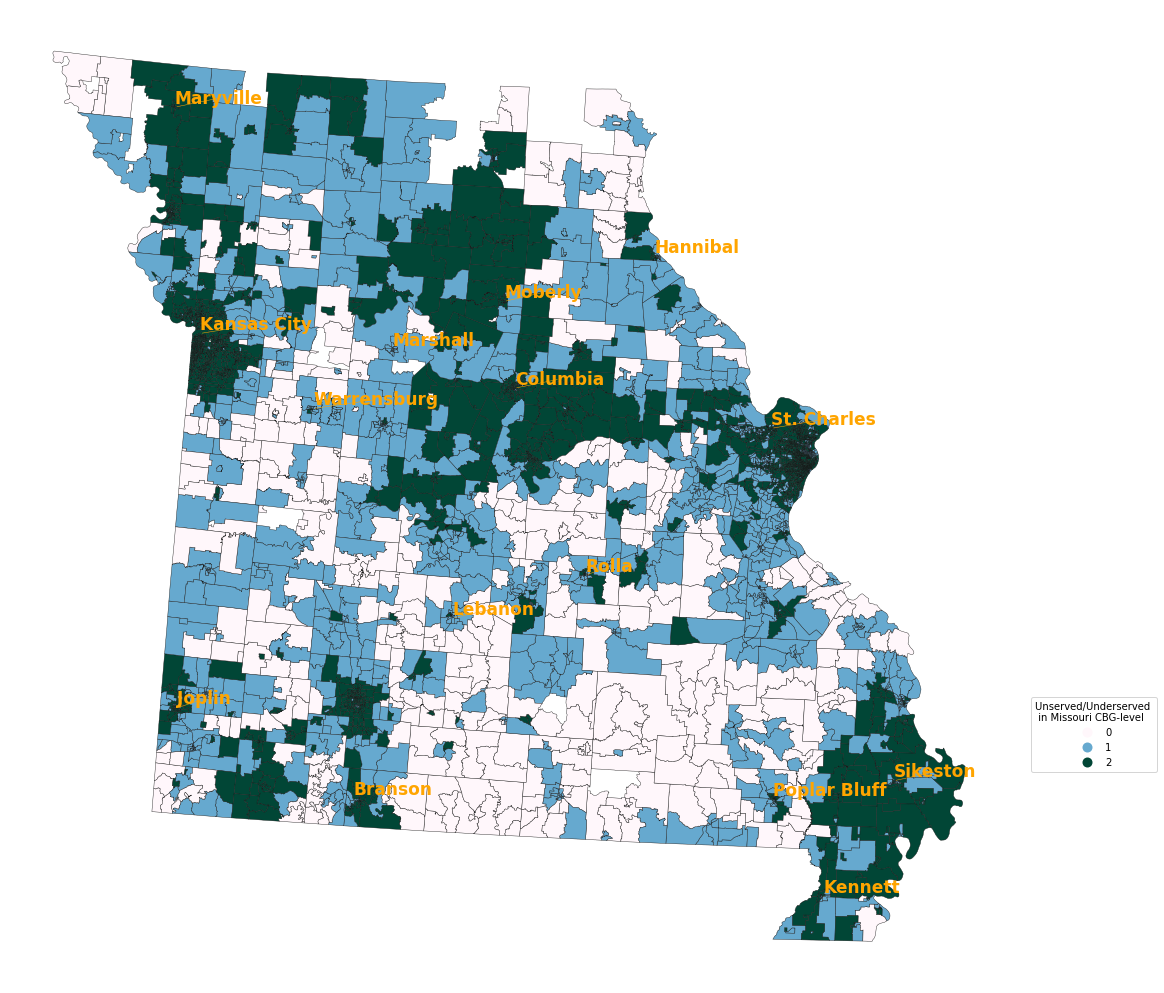

In [163]:
# restore geometry field (merging), for matplot plotting
weighted_cbgs_with_geometry = cbgs[['GEOID', 'geometry']].merge(weighted_cbgs, on='GEOID').to_crs(26916)
plot_data(weighted_cbgs_with_geometry, 'speedCatOokla', f"Unserved/Underserved \n in {state_name} CBG-level")

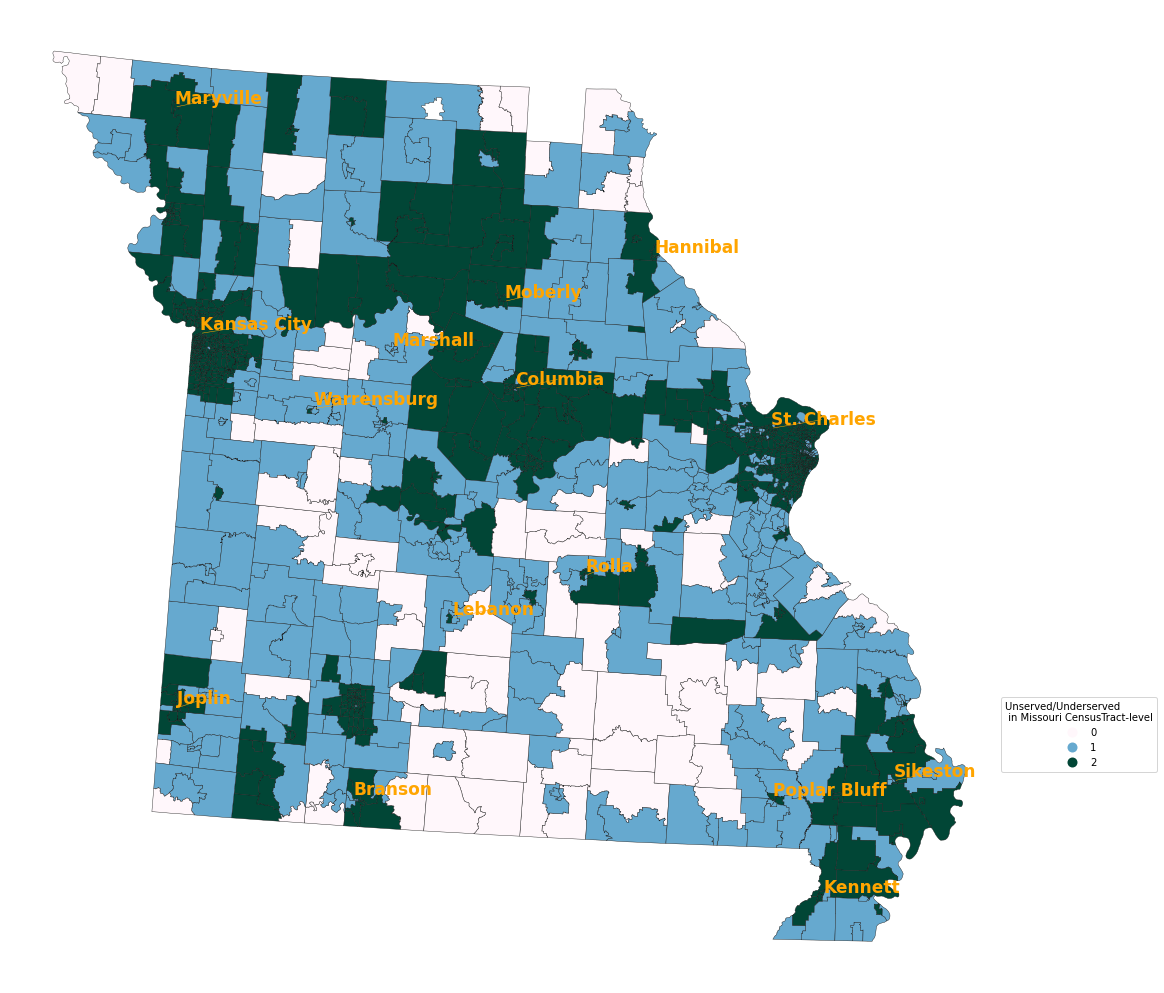

In [193]:
# restore geometry field (merging), for matplot plotting
weighted_tracts_with_geometry = tracts[['GEOID', 'geometry']].merge(weighted_tracts, on='GEOID').to_crs(26916)
plot_data(weighted_tracts_with_geometry, 'speedCatOokla', f"Unserved/Underserved \n in {state_name} CensusTract-level")

In [194]:
# NOTE: the type differences!
type(tracts) # geopandas.geodataframe.GeoDataFrame
type(weighted_tracts_with_geometry) # geopandas.geodataframe.GeoDataFrame
type(weighted_tracts) # pandas.core.frame.DataFrame

pandas.core.frame.DataFrame

# PART B -- SPEEDS: MLAB

# MLAB merge (speed w/ numTest & numDevice), and upload

In [5]:
STATE_FIPS_LENGTH = 2
COUNTY_FIPS_LENGTH = 5
TRACT_FIPS_LENGTH = 11
BLOCKGROUP_FIPS_LENGTH = 12
CENSUSBLOCK_FIPS_LENGTH = 15

MLAB_COLUMNS_LIST = [
    'GEOID',
    'meanDownloadMbpsMlab',
    'meanUploadMbpsMlab',
    'medDownloadMbpsMlab',
    'medUploadMbpsMlab',
    'maxDownloadMbpsMlab',
    'maxUploadMbpsMlab',
    'minDownloadMbpsMlab',
    'minUploadMbpsMlab',
    'numTestDownloadMlab',
    'numDeviceDownloadMlab',
    'numTestUploadMlab',
    'numDeviceUploadMlab',
    'speedCatMlab', # base on MEDIAN speeds
    'statefips',]

In [6]:
# ES INDEX management utils
def create_mlab_index(es, ES_ROW_GEOID, index_name):
    create_request_body = {
       "settings": {
        "refresh_interval": "1s",
        "number_of_shards": 1,
        "number_of_replicas": 0
      },
        "mappings":{
            "properties":{
                ES_ROW_GEOID            : { "type":"text"},
                "statefips"             : { "type": "text" },
                "speedCatMlab"          : { "type": "integer" },
                'numTestDownloadMlab'   : { "type": "integer"},
                'numDeviceDownloadMlab' : { "type": "integer"},
                'numTestUploadMlab'     : { "type": "integer"},
                'numDeviceUploadMlab'   : { "type": "integer"},
                "meanUploadMbpsMlab"    : { "type": "float" },
                "meanDownloadMbpsMlab"  : { "type": "float" },
                "medUploadMbpsMlab"     : { "type": "float" },
                "medDownloadMbpsMlab"   : { "type": "float" },
                "minUploadMbpsMlab"     : { "type": "float" },
                "minDownloadMbpsMlab"   : { "type": "float" },
                "maxUploadMbpsMlab"     : { "type": "float" },
                "maxDownloadMbpsMlab"   : { "type": "float" },
            }
        }
    } 

    es.indices.create(index = index_name, body = create_request_body)
    print('created index ', index_name)

# https://elasticsearch-py.readthedocs.io/en/v7.15.0/api.html#elasticsearch.client.IndicesClient.put_mapping\n",
def update_mlab_index(es, index_name):
    # adding new fields
    update_request_body = {
        "properties":{
            "speedCatMlab"          : { "type": "integer" },
            'numTestDownloadMlab'   : { "type": "integer"},
            'numDeviceDownloadMlab' : { "type": "integer"},
            'numTestUploadMlab'     : { "type": "integer"},
            'numDeviceUploadMlab'   : { "type": "integer"},
            "meanUploadMbpsMlab"    : { "type": "float" },
            "meanDownloadMbpsMlab"  : { "type": "float" },
            "medUploadMbpsMlab"     : { "type": "float" },
            "medDownloadMbpsMlab"   : { "type": "float" },
            "minUploadMbpsMlab"     : { "type": "float" },
            "minDownloadMbpsMlab"   : { "type": "float" },
            "maxUploadMbpsMlab"     : { "type": "float" },
            "maxDownloadMbpsMlab"   : { "type": "float" },
        }
    }
    es.indices.put_mapping(index = index_name, body = update_request_body)
    print('updated index ', index_name)


In [7]:
def add_speed_category_column_mlab(mlab_df):
    def helper(row):
        if row['medDownloadMbpsMlab'] < 25 or row['medUploadMbpsMlab'] < 3:
            return 0 # unserved
        if row['medDownloadMbpsMlab'] < 100 or row['medUploadMbpsMlab'] < 20:
            return 1 # underserved
        return 2
    # again: the speed category is based on the MEDIAN speeds
    mlab_df['speedCatMlab'] = mlab_df.apply(helper, axis = 1)

def merge_mlab_dfs(speed_df, numDevice_numTest_df):
    merged_df = pd.merge(speed_df, numDevice_numTest_df, how='inner', on='GEOID')
    
    merged_df = merged_df.rename(columns = {
        'download_MIN'   :  'minDownloadMbpsMlab',
        'download_MED'   :  'medDownloadMbpsMlab',
        'download_AVG'   :  'meanDownloadMbpsMlab',
        'download_MAX'   :  'maxDownloadMbpsMlab',
        'upload_MIN'     :  'minUploadMbpsMlab',
        'upload_MED'     :  'medUploadMbpsMlab',
        'upload_AVG'     :  'meanUploadMbpsMlab',
        'upload_MAX'     :  'maxUploadMbpsMlab',
        'num_test_down'  :  'numTestDownloadMlab',
        'num_device_down':  'numDeviceDownloadMlab',
        'num_test_up'    :  'numTestUploadMlab',
        'num_device_up'  :  'numDeviceUploadMlab',
    })
    
    # Add speed category column
    add_speed_category_column_mlab(merged_df)

    # Add statefips column
    merged_df['statefips'] = merged_df['GEOID'].str[:STATE_FIPS_LENGTH]
    
    # Retain only relevant columns
    merged_df = merged_df[MLAB_COLUMNS_LIST]
    
    print(merged_df.shape)
    return merged_df

## Upload MLAB STATE to ES index: new index boss_state

In [8]:
# 2021, Quarter 3
state_speeds = pd.read_csv('../MLAB/MLAB-state-2021Q3-speed.csv')
state_speeds = state_speeds.rename(columns = {'statefips' : 'GEOID'})
state_speeds['GEOID'] = state_speeds['GEOID'].astype(str).str.zfill(STATE_FIPS_LENGTH)
state_numDevice_numTest = pd.read_csv('../MLAB/MLAB-state-2021Q3-numTest-numDevice.csv')
state_numDevice_numTest['GEOID'] = state_numDevice_numTest['GEOID'].astype(str).str.zfill(STATE_FIPS_LENGTH)

# 56 state and territories (in 2021 survey, includes all 50 states, DC, and the US territories) (also  i.e. # of features in NTIA map)
# state_speeds.shape # (56, 10)
# state_numDevice_numTest.shape # (56, 5)

# # state that have speeds but no numDevice/numTest
# set(state_speeds['GEOID'].unique()) - set(state_numDevice_numTest['GEOID'].unique()) # set()
# # state that have numDevice/numTest but no speeds
# set(state_numDevice_numTest['GEOID'].unique()) - set(state_speeds['GEOID'].unique())

merged_mlab_state = merge_mlab_dfs(state_speeds, state_numDevice_numTest)
merged_mlab_state = merged_mlab_state.drop(columns=['statefips'])
merged_mlab_state.tail()

(56, 15)


,GEOID,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab
51,60,13.01,8.39,8.96,5.87,125.94,141.57,0.01,0.02,327,58,363,59,0
52,66,25.69,3.14,15.25,2.21,102.97,32.13,0.00,0.01,2002,324,2214,342,0
53,69,19.37,5.45,14.87,3.60,136.97,93.08,0.06,0.07,103,63,114,69,0
54,72,60.93,22.47,21.80,7.66,694.85,690.43,0.00,0.00,52078,9735,97442,10175,0
55,78,29.79,14.70,14.20,7.59,246.14,111.09,0.00,0.01,3653,371,5569,374,0


In [9]:
merged_mlab_state[['GEOID', 
                   'medDownloadMbpsMlab', 
                   'medUploadMbpsMlab', 'speedCatMlab']].head()

index_name = "boss_state"
ES_ROW_GEOID = 'statefips'

merged_mlab_state = merged_mlab_state.rename(columns={'GEOID' : ES_ROW_GEOID})
merged_mlab_state.head()
merged_mlab_state.shape # (56, 4)

# RUN ONCE
# create_mlab_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE
# update_mlab_index(es, index_name)

# UPLOAD/UPDATE data in the index: RUN ONCE
# upload_df(es, merged_mlab_state, index_name, ES_ROW_GEOID, 'update')


,GEOID,medDownloadMbpsMlab,medUploadMbpsMlab,speedCatMlab
0,01,49.16,9.93,1
1,02,23.36,5.74,0
2,04,56.97,9.30,1
3,05,42.65,7.99,1
4,06,69.47,10.56,1


## Upload MLAB COUNTY to ES index: boss_county

In [11]:
# GENERATE: 2021, Quarter 3
county_speeds = pd.read_csv('../MLAB/MLAB-county-2021Q3-speed.csv')
county_speeds = county_speeds.rename(columns = {'county_fips_code' : 'GEOID'})
county_speeds['GEOID'] = county_speeds['GEOID'].astype(str).str.zfill(COUNTY_FIPS_LENGTH)
county_numDevice_numTest = pd.read_csv('../MLAB/MLAB-county-2021Q3-numTest-numDevice.csv')
county_numDevice_numTest['GEOID'] = county_numDevice_numTest['GEOID'].astype(str).str.zfill(COUNTY_FIPS_LENGTH)

# 97% V.S. total 3233 counties (in 2021 survey, includes all 50 states, DC, and the US territories) (also  i.e. # of features in NTIA map)
county_speeds.shape # (3216, 10)
county_numDevice_numTest.shape # (3216, 5)

# # counties that have speeds but no numDevice/numTest
# set(county_speeds['GEOID'].unique()) - set(county_numDevice_numTest['GEOID'].unique()) # set()
# # counties that have numDevice/numTest but no speeds
# set(county_numDevice_numTest['GEOID'].unique()) - set(county_speeds['GEOID'].unique())

merged_mlab_county = merge_mlab_dfs(county_speeds, county_numDevice_numTest)
merged_mlab_county.tail()

(3216, 15)


,GEOID,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,statefips
3211,72151,238.60,128.98,186.21,95.03,645.91,427.36,0.11,0.14,103,17,121,17,2,72
3212,72153,32.97,17.75,31.26,16.70,189.83,91.18,0.01,0.30,66,16,79,18,1,72
3213,78010,29.93,15.01,13.11,7.38,246.14,104.81,0.03,0.01,3236,346,5153,350,0,78
3214,78020,10.68,5.26,10.65,5.23,26.65,8.93,0.38,0.43,26,6,31,6,0,78
3215,78030,29.90,12.03,27.26,10.21,104.74,111.09,0.00,0.89,386,17,383,16,1,78


In [ ]:
### Extra: aggregate county results into states, and validate #test, #device

# county_state_aggregated = merged_mlab_county.groupby(['statefips']).sum() # GEOID_c is now the index
# county_state_aggregated['GEOID'] = county_state_aggregated.index

# county_state_aggregated = county_state_aggregated[['GEOID', 'num_test_down', 'num_device_down', 'num_test_up', 'num_device_up']]
# county_state_aggregated.head()

In [ ]:
# ### Extra: Validation against NTIA Map's MLAB county data

# # 2020, quarter 1 plus quarter 2
# ntia_2020_counties_1 = pd.read_csv('../MLAB/bigquery/NTIA-map-all-county-2020q1q2-part1.csv')
# ntia_2020_counties_2 = pd.read_csv('../MLAB/bigquery/NTIA-map-all-county-2020q1q2-part2.csv')
# ntia_2020_all_counties = pd.concat([ntia_counties_1, ntia_counties_2], ignore_index=True)
# ntia_2020_all_counties.to_csv('../MLAB/igquery/NTIA-map-all-county-2020q1q2-merged.csv')
# ntia_2020_all_counties.shape # (3219, 12) non-blank MLab results, out of total 3233 counties (in 2021, and in BigQuery public data set)

# mlab_2020_counties = pd.read_csv('../MLAB/bigquery/MLAB-county-NTIA-2020q1q2.csv')
# mlab_2020_counties.shape # (3137, 3)

# len(ntia_2020_all_counties['State'].unique()) # 56 STATES and TERRITORIES
# len(ntia_2020_all_counties['Geographic Identifier - FIPS Code'].unique()) # 3219

# ntia_meds = ntia_2020_all_counties[['M-Lab Median Download Speed (Mbps)', 'M-Lab Median Upload Speed (Mbps)']].median()[:2]
# ntia_meds

# my_meds = mlab_2020_counties.median()[:3]
# my_meds

# # PRETTY GOOD RESULT for validation purposes!
# my_means[0]/ntia_means[0], my_means[1]/ntia_means[1]
# # (0.9600933285536307, 0.9672973934097263)
# my_meds[0]/ntia_meds[0], my_meds[1]/ntia_meds[1]
# # (0.9999251860129577, 0.9997801926364297)


In [12]:
# UPLOAD
index_name = "boss_county"
ES_ROW_GEOID = 'GEOID_c'

merged_mlab_county = merged_mlab_county.rename(columns={'GEOID' : ES_ROW_GEOID})
merged_mlab_county.head()
merged_mlab_county.shape # (3133, 15)

# RUN ONCE
# create_mlab_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE
# update_mlab_index(es, index_name)

# UPLOAD/UPDATE data in the index: RUN ONCE
# upload_df(es, merged_mlab_county, index_name, ES_ROW_GEOID, 'update')


(3216, 15)

## Upload MLAB TRACT to new index: speed_mlab_2021q3_ct_all_states

In [13]:
tract_speeds = pd.read_csv('../MLAB/MLAB-tract-2021Q3-speed.csv')
tract_speeds['GEOID'] = tract_speeds['GEOID'].astype(str).str.zfill(TRACT_FIPS_LENGTH)
tract_numDevice_numTest = pd.read_csv('../MLAB/MLAB-tract-2021Q3-numTest-numDevice.csv')
tract_numDevice_numTest['GEOID'] = tract_numDevice_numTest['GEOID'].astype(str).str.zfill(TRACT_FIPS_LENGTH)

# V.S. total 74133 tracts
# NOTE: only ~ 30% of tracts has Mlab data!
# tract_speeds.shape # (22540, 9)
# tract_numDevice_numTest.shape # (22555, 5)

# # tracts that have speeds but no numDevice/numTest
# set(tract_speeds['GEOID'].unique()) - set(tract_numDevice_numTest['GEOID'].unique()) # set()
# # tracts that have numDevice/numTest but no speeds
# set(tract_numDevice_numTest['GEOID'].unique()) - set(tract_speeds['GEOID'].unique())

merged_mlab_tract = merge_mlab_dfs(tract_speeds, tract_numDevice_numTest)
merged_mlab_tract.tail()

(22540, 15)


,GEOID,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,statefips
22535,78010970800,18.89,4.23,18.88,4.04,54.77,15.26,0.32,0.08,31,23,42,26,0,78
22536,78010971100,83.76,9.84,74.87,8.45,198.32,83.48,0.07,0.04,444,18,440,16,1,78
22537,78010990000,11.37,7.20,5.70,3.78,246.14,104.81,0.03,0.01,869,88,1982,83,0,78
22538,78020950200,10.68,5.26,10.65,5.23,26.65,8.93,0.38,0.43,26,6,31,6,0,78
22539,78030961000,29.90,12.03,27.26,10.21,104.74,111.09,0.00,0.89,386,17,383,16,1,78


In [ ]:
# #### Validation: Confirm that tracts data (numTest and numDevice) add up to County data

# tract_complete['GEOID_c'] = tract_complete['GEOID'].str[:COUNTY_FIPS_LENGTH]

# tract_county_aggregated = tract_complete.groupby(['GEOID_c']).sum() # GEOID_c is now the index
# tract_county_aggregated['GEOID'] = tract_county_aggregated.index

# tract_county_aggregated = tract_county_aggregated[['GEOID', 'num_test_down', 'num_device_down', 'num_test_up', 'num_device_up']]
# tract_county_aggregated.head()

# # LOOKED GOOD!

#### TODO: maybe later: more validation: error percentage (overshoot of num_device because sum of # individual devices in all tracts should be larger than # individual devices in county
#### Also, verify that the aggregated max, min, mean, and median from individual tracts fall within expected values of county

In [14]:
index_name = "speed_mlab_2021q3_ct_all_states"
ES_ROW_GEOID = 'GEOID_ct'

merged_mlab_tract = merged_mlab_tract.rename(columns={'GEOID' : ES_ROW_GEOID})
merged_mlab_tract.head()

# RUN ONCE
# create_mlab_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE if needed
# update_mlab_index(es, index_name)

# UPLOAD/UPDATE data in the index: RUN ONCE
# upload_df(es, merged_mlab_tract, index_name, ES_ROW_GEOID, 'update')


,GEOID_ct,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,statefips
0,01001020100,135.93,56.11,84.29,25.76,934.81,901.15,0.08,0.01,2222,516,2131,481,1,01
1,01001020500,136.84,39.75,84.46,17.83,928.13,886.40,0.09,0.01,3078,553,3111,533,1,01
2,01001020900,39.70,30.98,36.87,30.75,221.44,199.76,1.51,0.08,61,31,56,30,1,01
3,01001021000,28.99,8.34,23.22,6.69,106.09,48.20,0.28,0.01,51,40,38,31,0,01
4,01001021100,142.58,89.67,133.40,81.39,208.18,208.35,6.40,0.64,10,6,21,16,2,01


## Upload MLAB BLOCKGROUP to new index: speed_mlab_2021q3_cbg_all_states

In [15]:
blockgroup_speeds = pd.read_csv('../MLAB/MLAB-blockgroup-2021Q3-speed.csv')
blockgroup_speeds['GEOID'] = blockgroup_speeds['GEOID'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)
blockgroup_numDevice_numTest = pd.read_csv('../MLAB/MLAB-blockgroup-2021Q3-numTest-numDevice.csv')
blockgroup_numDevice_numTest['GEOID'] = blockgroup_numDevice_numTest['GEOID'].astype(str).str.zfill(BLOCKGROUP_FIPS_LENGTH)

# V.S. total 220,740 blockgroups 
# NOTE: only ~ 12% of block groups has Mlab data!
# blockgroup_speeds.shape # (27150, 9)
# blockgroup_numDevice_numTest.shape # (27262, 15)

# # blockgroups that have speeds but no numDevice/numTest
# set(blockgroup_speeds['GEOID'].unique()) - set(blockgroup_numDevice_numTest['GEOID'].unique()) # set()
# # blockgroups that have numDevice/numTest but no speeds
# set(blockgroup_numDevice_numTest['GEOID'].unique()) - set(blockgroup_speeds['GEOID'].unique())

merged_mlab_blockgroup = merge_mlab_dfs(blockgroup_speeds, blockgroup_numDevice_numTest)
merged_mlab_blockgroup.tail()


(27262, 15)


,GEOID,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,statefips
27257,780109708002,18.89,4.23,18.88,4.04,54.77,15.26,0.32,0.08,31,23,42,26,0,78
27258,780109711003,83.76,9.84,74.87,8.45,198.32,83.48,0.07,0.04,444,18,440,16,1,78
27259,780109900000,11.37,7.20,5.70,3.78,246.14,104.81,0.03,0.01,869,88,1982,83,0,78
27260,780209502003,10.68,5.26,10.65,5.23,26.65,8.93,0.38,0.43,26,6,31,6,0,78
27261,780309610004,29.90,12.03,27.26,10.21,104.74,111.09,0.00,0.89,386,17,383,16,1,78


In [ ]:
#### Validation: Confirm that blockgroup data (numTest and numDevice) add up to tract data

# blockgroup_complete['GEOID_ct'] = blockgroup_complete['GEOID'].str[:TRACT_FIPS_LENGTH]

# blockgroup_tract_aggregated = blockgroup_complete.groupby(['GEOID_ct']).sum() # GEOID_ct is now the index
# blockgroup_tract_aggregated['GEOID'] = blockgroup_tract_aggregated.index

# blockgroup_tract_aggregated = blockgroup_tract_aggregated[['GEOID', 'num_test_down', 'num_device_down', 'num_test_up', 'num_device_up']]
# blockgroup_tract_aggregated.head()

# # LOOKED GOOD!

In [16]:
index_name = "speed_mlab_2021q3_cbg_all_states"
ES_ROW_GEOID = 'GEOID_cbg'

merged_mlab_blockgroup = merged_mlab_blockgroup.rename(columns={'GEOID' : ES_ROW_GEOID})
merged_mlab_blockgroup.tail()

# RUN ONCE
# create_mlab_index(es, ES_ROW_GEOID, index_name)

# RUN ONCE if needed
# update_mlab_index(es, index_name)

# UPLOAD/UPDATE data in the index: RUN ONCE
# upload_df(es, merged_mlab_blockgroup, index_name, ES_ROW_GEOID, 'update')


,GEOID_cbg,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,statefips
27257,780109708002,18.89,4.23,18.88,4.04,54.77,15.26,0.32,0.08,31,23,42,26,0,78
27258,780109711003,83.76,9.84,74.87,8.45,198.32,83.48,0.07,0.04,444,18,440,16,1,78
27259,780109900000,11.37,7.20,5.70,3.78,246.14,104.81,0.03,0.01,869,88,1982,83,0,78
27260,780209502003,10.68,5.26,10.65,5.23,26.65,8.93,0.38,0.43,26,6,31,6,0,78
27261,780309610004,29.90,12.03,27.26,10.21,104.74,111.09,0.00,0.89,386,17,383,16,1,78


## Census Block: use-case MO statefips=29

- Missouri has 1,393 census tracts, 4,506 block groups, and 343,565 census blocks.

- 845/343565 * 100 # 0.24% coverage, terrible!

# Export complete mlab data to csv files

In [36]:
# merged_mlab_state.to_csv('../MLAB/MLAB-merged-state-2021Q3.csv', index = False)
# merged_mlab_county.to_csv('../MLAB/MLAB-merged-county-2021Q3.csv', index = False)
# merged_mlab_tract.to_csv('../MLAB/MLAB-merged-tract-2021Q3.csv', index = False)
# merged_mlab_blockgroup.to_csv('../MLAB/MLAB-merged-blockgroup-2021Q3.csv', index = False)


### NOT NEEDED: IMPUTING Ookla missing values

In [ ]:
# INTERPOLATE_DICT = {'cb': {}, 'cbg': {}, 'ct': {}, 'county': {}}

# for each statefips:
#     for each censusblock:
#         blockgroup_fips, tract_fips, county_fips, state_fips = extract_fips(GEOID)
        
#         if speedCatMlab is None:
            
#         if speedCatOokla is None:
            

# Regression: overview of datasets

In [33]:
round(geom_mlab_blockgroup.describe(), 2)

,meanDownloadMbpsMlab,meanUploadMbpsMlab,medDownloadMbpsMlab,medUploadMbpsMlab,maxDownloadMbpsMlab,maxUploadMbpsMlab,minDownloadMbpsMlab,minUploadMbpsMlab,numTestDownloadMlab,numDeviceDownloadMlab,numTestUploadMlab,numDeviceUploadMlab,speedCatMlab,lat,lng
count,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00,27262.00
mean,91.11,34.25,64.51,21.96,594.50,441.21,4.75,1.74,2626.98,617.93,2657.32,572.25,0.86,-90.61,38.54
std,67.33,44.61,54.88,37.31,473.41,420.35,31.40,19.74,32366.63,1889.70,34278.82,1725.49,0.58,15.62,5.28
min,0.02,0.01,0.02,0.01,0.02,0.01,0.00,0.00,1.00,1.00,1.00,1.00,0.00,-170.78,-14.34
25%,36.45,9.57,26.65,6.27,191.28,52.73,0.04,0.01,45.00,14.00,41.00,14.00,1.00,-96.79,35.04
50%,83.72,19.56,56.90,10.93,608.36,298.74,0.12,0.02,277.00,68.00,264.00,66.00,1.00,-87.79,39.31
75%,133.90,43.57,87.54,23.19,920.58,890.95,0.61,0.07,2042.00,533.00,2002.00,501.75,1.00,-80.18,42.01
max,977.56,919.00,952.00,919.00,7446.04,7307.57,951.08,919.00,4600033.00,122311.00,4743743.00,110948.00,2.00,145.76,71.21


### Correlation analysis

<AxesSubplot:>

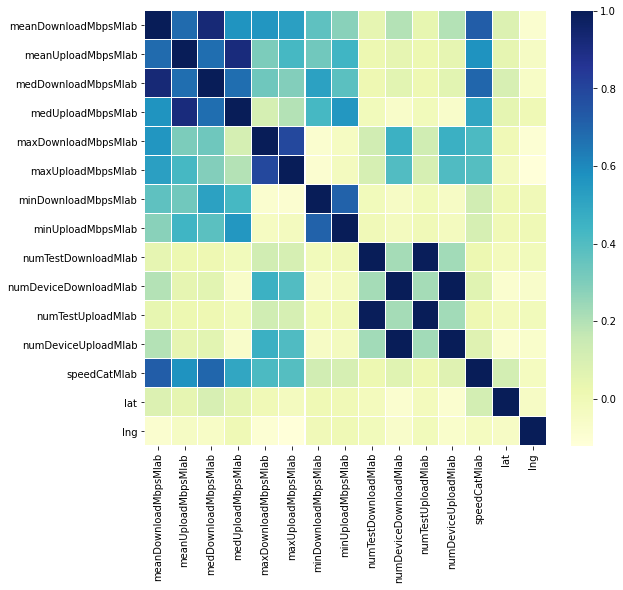

In [191]:
# geom_mlab_blockgroup.corr()

corrmat = geom_mlab_blockgroup.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [58]:
predictors = ['lat', 'lng', 'numTestDownloadMlab', 'numDeviceDownloadMlab', 
            'numTestUploadMlab', 'numDeviceUploadMlab', 'maxDownloadMbpsMlab',
       'maxUploadMbpsMlab', 'minDownloadMbpsMlab', 'minUploadMbpsMlab',]
# predictors = ['numTestDownloadMlab', 'numDeviceDownloadMlab', 
#             'numTestUploadMlab', 'numDeviceUploadMlab', 'maxDownloadMbpsMlab',
#        'maxUploadMbpsMlab', 'minDownloadMbpsMlab', 'minUploadMbpsMlab',]
# predictors = ['numTestDownloadMlab', 'numDeviceDownloadMlab', 'maxDownloadMbpsMlab',
#        'maxUploadMbpsMlab', 'minDownloadMbpsMlab', 'minUploadMbpsMlab',]
# predictors = ['lat', 'lng', 'maxDownloadMbpsMlab',
#        'maxUploadMbpsMlab', 'minDownloadMbpsMlab', 'minUploadMbpsMlab',]


responses = ['medDownloadMbpsMlab']
# responses = ['medDownloadMbpsMlab', 'medUploadMbpsMlab']


Xm = geom_mlab_blockgroup[predictors].values
y = geom_mlab_blockgroup[responses].values

# Split data
Xm_train, Xm_test, y_train, y_test = train_test_split(Xm, y, test_size=0.2, random_state=1)

## How to Improve a Machine Learning Model
There are three general approaches for improving an existing machine learning model:
- Use more (high-quality) data [[the amount of useful data is more important to the problem than the complexity of the model.]] and feature engineering
- Tune the hyperparameters of the algorithm
- Try different algorithms

#### Separate dataset: X (i.e. Attributes/Predictors) from y (i.e. Label/Response)

#### Feature engineering

In [345]:
# https://machinelearningmastery.com/feature-selection-for-regression-data/

### Hyperparameter Tuning: a primer

An overfit model may look impressive on the training set, but will be useless in a real application (test data set). Therefore, the standard procedure for hyperparameter optimization accounts for overfitting through cross validation.

When we approach a machine learning problem, we make sure to split our data into a training and a testing set. In K-Fold CV, we further split our training set into K number of subsets, called folds. We then iteratively fit the model K times, each time training the data on K-1 of the folds and evaluating on the Kth fold (called the validation data)

At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.

For hyperparameter tuning, we perform many iterations of the entire K-Fold CV process, each time using different model settings.

We then compare all of the models, select the best one, train it on the full training set, and then evaluate on the testing set. 


## 3 Predictive Regression Models

### 1. Multiple Linear Regression (MLR)

In [311]:
# Define model
model = LinearRegression()  
# fit model
model.fit(Xm_train, y_train)

# Co-efficients
coeff = pd.DataFrame(model.coef_, index=responses).transpose() 
pd.concat([pd.DataFrame(predictors), coeff], axis=1, join='inner')


,0,medDownloadMbpsMlab
0,lat,0.303814
1,lng,-0.087294
2,numTestDownloadMlab,0.000208
3,numDeviceDownloadMlab,0.015712
4,numTestUploadMlab,-0.000209
5,numDeviceUploadMlab,-0.020720
6,maxDownloadMbpsMlab,0.039550
7,maxUploadMbpsMlab,0.015943
8,minDownloadMbpsMlab,0.962214
9,minUploadMbpsMlab,0.019105


In [312]:
# Prediction on test data
y_model_pred = model.predict(Xm_test)

print('Mean Absolute Error MAE:', metrics.mean_absolute_error(y_test, y_model_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_model_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_model_pred)))

model_test_pred = pd.DataFrame({'Observed': y_test.flatten(), 'Predicted': y_model_pred.flatten()})
model_test_pred.sample(frac=0.1, random_state=1)

Mean Absolute Error MAE: 28.362564282456653
Mean Squared Error: 1823.5379746486128
Root Mean Squared Error: 42.70290358568856


,Observed,Predicted
3738,147.20,80.221895
1056,58.61,64.936565
2331,88.57,75.408351
5184,15.89,37.392151
3822,104.66,84.788905
...,...,...
555,72.07,49.864807
574,9.95,37.528362
4044,39.11,44.916920
1768,16.45,40.313025


Text(0.5, 1.0, 'Predicted speeds')

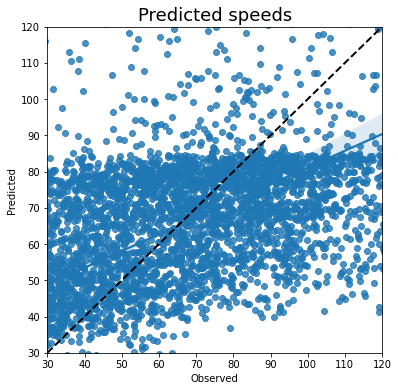

In [190]:
plt.figure(figsize=(6, 6))
ax = sns.regplot(x="Observed", y="Predicted", data=mlr_test_pred)
ax.set_ylim(30,120)
ax.set_xlim(30,120)
ax.plot([30, 120], [30, 120], 'k--', lw=2)
plt.title('Predicted speeds',fontsize=18)

### Cross-validation: evaluating estimator performance: Not needed
Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.



### 2. MultiTask Lasso CV / sklearn.linear_model.Lasso

In [318]:
# # Hyperparameter (alpha) optimization with cross-validation estimator CV

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# model = MultiTaskLassoCV(alphas=arange(0, 1, .1), cv=cv, n_jobs=-1)
# model.fit(Xm_train, y_train)
# print('alpha: %f' % model.alpha_) # Always get arbitrary alpha, this time alpha= 0.6


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15772103.669416478, tolerance: 5634.107170278537
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16127453.754181994, tolerance: 5643.456846986148
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:518: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15897461.235589812, tolerance: 5766.1385700250075
  model = cd_fast.enet_coordinate_descent_multi_task(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordin

alpha: 0.600000


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1951: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17852764.060844038, tolerance: 6360.1495479463465
  cd_fast.enet_coordinate_descent_multi_task(


In [59]:
# Define model evaluation method
# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define tuning-hyperparameter (i.e. alpha or penalty coeff) model
# model = LassoCV(alphas=arange(0, 1, .1), cv=cv, n_jobs=-1)
# model.fit(Xm_train, y_train)
# summarize chosen configuration
# print('alpha: %f' % model.alpha_) # Always get arbitrary alpha

# define model
model = MultiTaskLasso(alpha = 0.6)
# fit model
model.fit(Xm_train, y_train)

# Co-efficients
coeff = pd.DataFrame(model.coef_, index=responses).transpose() 
pd.concat([pd.DataFrame(predictors), coeff], axis=1, join='inner')


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1951: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17852764.060843922, tolerance: 6360.1495479463465
  cd_fast.enet_coordinate_descent_multi_task(


,0,medDownloadMbpsMlab
0,lat,0.301539
1,lng,-0.063318
2,numTestDownloadMlab,0.000249
3,numDeviceDownloadMlab,0.012572
4,numTestUploadMlab,-0.000247
5,numDeviceUploadMlab,-0.017280
6,maxDownloadMbpsMlab,0.039510
7,maxUploadMbpsMlab,0.015961
8,minDownloadMbpsMlab,0.962602
9,minUploadMbpsMlab,0.017058


In [60]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance', model)
    print('Average Error: {:0.4f} Mbps.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

evaluate(model, Xm_test, y_test)

# Prediction on test data
y_predict = model.predict(Xm_test)

print('Mean Absolute Error MAE:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

y_test_vs_pred = pd.DataFrame({'Observed': y_test.flatten(), 'Predicted': y_predict.flatten()})
y_test_vs_pred.sample(frac=0.1, random_state=1)

Mean Absolute Error MAE: 28.358503030923654
Mean Squared Error: 1824.1577217368822
Root Mean Squared Error: 42.71015946747193


,Observed,Predicted
3738,147.20,80.250461
1056,58.61,64.763761
2331,88.57,75.536918
5184,15.89,37.598518
3822,104.66,84.827712
...,...,...
555,72.07,49.928989
574,9.95,37.459319
4044,39.11,44.741454
1768,16.45,40.146430


In [ ]:
# Prediction on test data
y_model_pred = model.predict(Xm_test)

print('Mean Absolute Error MAE:', metrics.mean_absolute_error(y_test, y_model_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_model_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_model_pred)))

model_test_pred = pd.DataFrame({'Observed': y_test.flatten(), 'Predicted': y_model_pred.flatten()})
model_test_pred.sample(frac=0.1, random_state=1)

plt.figure(figsize=(6, 6))
ax = sns.regplot(x="Observed", y="Predicted", data=model_test_pred)
ax.set_ylim(30,120)
ax.set_xlim(30,120)
ax.plot([30, 120], [30, 120], 'k--', lw=2)
plt.title('Predicted speeds',fontsize=18)

In [308]:
# CONCLUSION: Lasso Reg gives the ~ same result as Linear Reg

### 3. Random Forest Reg. / sklearn.ensemble.RandomForestRegressor

In [54]:
# Just select all available features
predictors = ['lat', 'lng', 'numTestDownloadMlab', 'numDeviceDownloadMlab', 
            'numTestUploadMlab', 'numDeviceUploadMlab', 'maxDownloadMbpsMlab',
       'maxUploadMbpsMlab', 'minDownloadMbpsMlab', 'minUploadMbpsMlab',]

response = 'medDownloadMbpsMlab'

Xm = geom_mlab_blockgroup[predictors].values
y = geom_mlab_blockgroup[response].values # response var

# Split data
Xm_train, Xm_test, y_train, y_test = train_test_split(Xm, y, test_size=0.2, random_state=1)

In [55]:
# n_estimators parameter: important param that defines the number of trees in the random forest.
model = RandomForestRegressor(n_estimators=100, random_state=0)
# fit model
model.fit(Xm_train, y_train)
print("Evaluation on training data/ Score: R-squared:", model.score(Xm_train, y_train)) 
# Evaluation on training data/ Score: R-squared: 0.9596990667174186


Evaluation on training data/ Score: R-squared: 0.9596990667174186


In [56]:
# Prediction on test data
y_predict = model.predict(Xm_test)

print('Mean Absolute Error MAE:', metrics.mean_absolute_error(y_test, y_predict))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_predict)))

y_test_vs_pred = pd.DataFrame({'Observed': y_test.flatten(), 'Predicted': y_predict.flatten()})
y_test_vs_pred.sample(frac=0.1, random_state=1)

Mean Absolute Error MAE: 19.37368899688245
Mean Squared Error: 1019.5460433342581
Root Mean Squared Error: 31.930331087138107


,Observed,Predicted
3738,147.20,109.7796
1056,58.61,36.3953
2331,88.57,81.9746
5184,15.89,14.7662
3822,104.66,110.7226
...,...,...
555,72.07,51.9664
574,9.95,15.4169
4044,39.11,39.2561
1768,16.45,17.2411


#### Hyperparameter Tuning: n_estimators

In [357]:
print('Parameters currently in use:\n')
from pprint import pprint
pprint(model.get_params())

# n_estimators = number of trees in the foreset
# max_features = max number of features considered for splitting a node
# max_depth = max number of levels in each decision tree
# min_samples_split = min number of data points placed in a node before the node is split
# min_samples_leaf = min number of data points allowed in a leaf node
# bootstrap = method for sampling data points (with or without replacement)

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


- NOTE: Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

#### Hyperparameter tuning: Part 1: Random search 

- The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation. 
- More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [49]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# pprint(random_grid)
# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [365]:
# Base model to tune
model = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 20, cv = 2, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
model_random.fit(Xm_train, y_train)



Fitting 3 folds for each of 100 candidates, totalling 300 fits


NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [366]:
print("Evaluation on training data/ Score: R-squared:", model_random.score(Xm_train, y_train)) 

Evaluation on training data/ Score: R-squared: 0.8928723998578441


In [367]:
# the best parameters from fitting the random search
model_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [1]:
rf_model = RandomForestRegressor('n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True)

SyntaxError: invalid syntax (<ipython-input-1-f95d727e95c0>, line 1)

#### Compare base model and random search

In [369]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance', model)
    print('Average Error: {:0.4f} Mbps.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

# BASE Random Forest MODEL
base_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
base_model.fit(Xm_train, y_train)
base_accuracy = evaluate(base_model, Xm_test, y_test)

# Random Search Random Forest MODEL
best_random = model_random.best_estimator_
random_accuracy = evaluate(best_random, Xm_test, y_test)

print('base_randomForest >> randomSearch_randomForest:: Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance RandomForestRegressor(n_estimators=10, random_state=0)
Average Error: 20.3967 Mbps.
Accuracy = 52.48%.
Model Performance RandomForestRegressor(max_depth=100, min_samples_leaf=4, min_samples_split=5,
                      n_estimators=1600)
Average Error: 19.1922 Mbps.
Accuracy = 55.17%.
base_randomForest >> randomSearch_randomForest:: Improvement of 5.14%.


#### Hyperparameter further-tuning: Part 2: Grid Search

- Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try.

In [372]:
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 100,],
    'max_features': [3],
    'min_samples_leaf': [4, 5],
    'min_samples_split': [5, 8],
    'n_estimators': [500, 1000, 1600]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(Xm_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'max_features': [3], 'min_samples_leaf': [4, 5],
                         'min_samples_split': [5, 8],
                         'n_estimators': [500, 1000, 1600]},
             verbose=2)

In [373]:
grid_search.best_params_


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 1600}

In [374]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, Xm_test, y_test)
print('base_randomForest >> gridSearch_randomForest:: Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


Model Performance RandomForestRegressor(max_depth=80, max_features=3, min_samples_leaf=4,
                      min_samples_split=8, n_estimators=1600)
Average Error: 19.2852 Mbps.
Accuracy = 50.18%.
base_randomForest >> gridSearch_randomForest:: Improvement of -4.37%.


#### Feature importances

#### Prediction and Evaluation

In [343]:
# Prediction on test data
y_pred = model.predict(Xm_test)

print('Mean Absolute Error MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

model_test_pred = pd.DataFrame({'Observed': y_test.flatten(), 'Predicted': y_pred.flatten()})
model_test_pred.sample(frac=0.1, random_state=1)

Mean Absolute Error MAE: 19.37368899688245
Mean Squared Error MSE: 1019.5460433342581
Root Mean Squared Error: 31.930331087138107


,Observed,Predicted
3738,147.20,109.7796
1056,58.61,36.3953
2331,88.57,81.9746
5184,15.89,14.7662
3822,104.66,110.7226
...,...,...
555,72.07,51.9664
574,9.95,15.4169
4044,39.11,39.2561
1768,16.45,17.2411


Text(0.5, 1.0, 'Predicted speeds')

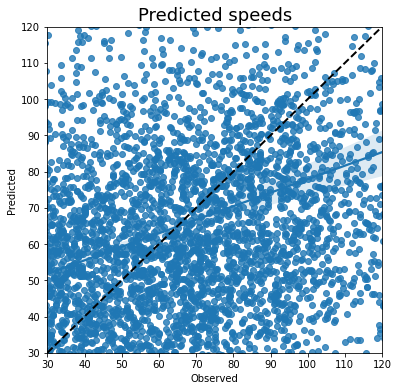

In [332]:
plt.figure(figsize=(6, 6))
ax = sns.regplot(x="Observed", y="Predicted", data=model_test_pred)
ax.set_ylim(30,120)
ax.set_xlim(30,120)
ax.plot([30, 120], [30, 120], 'k--', lw=2)
plt.title('Predicted speeds',fontsize=18)

# x_ax = range(len(y_test))
# plt.plot(x_ax, y_test, linewidth=1, label="Observed")
# plt.plot(x_ax, y_pred, linewidth=1.1, label="Predicted")
# plt.title("y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show() 